# Benchmarking space charge in the linear IOTA 8.2 lattice

This notebook performs simple simulations of the linear IOTA 8.2 lattice with a fixed bunch current, and evaluates the bunch behavior in terms of envelope and emittance evolution as well as tune depression. The goal of the notebook is to verify that the proper space charge tune depression is achieved in the IOTA lattice for matching bunches with specially tailored lattice variants. This notebook, the associated scripts, and a host of other resources can be found at RadiaSoft's [rssynergia](https://github.com/radiasoft/rssynergia) github repository: https://github.com/radiasoft/rssynergia.

*NOTE: Lattice files may be found in the corresponding [ioptics](https://github.com/radiasoft/ioptics) repository.*

**Basic Simulation Parameters**

- IOTA v8.2 lattice with 1 integrable optics drift section (no nonlinear magnet in place)
- Sextupole strengths set to zero
- Full CHEF propagation - symplectic single particle tracking including nonlinear effects
- Each element in the lattice is sliced into 4 segments for computing dynamics.

**Basic Beam Parameters**

- 2.5 MeV proton beam
- KV distribution with total geometric emittance of 20 mm-mrad
- 4.25 mA of current, corresponding to 4.854214e+10 total protons or 1.214518e+07 p+/cm around the ring.

**Specific setup notes** 

1. Be sure to have the rssynergia repo in your path
2. Adjust the `dir_66` and `dir_82` values in code block **6** to match the location of your lattice files.
3. If you do not have the watermark package, then its import may be commented out as its non-essential to running the notebook. 

## Imports

In [1]:
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2

In [2]:
%watermark -d -v -a 'Nathan Cook'

Nathan Cook 25/04/2016 

CPython 2.7.10
IPython 4.0.2


In [3]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy import constants
import tables
from mpi4py import MPI

In [4]:
from base_diagnostics import utils
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from base_diagnostics import lfplot
from base_diagnostics import latticework
from base_diagnostics import basic_calcs
from base_diagnostics import pltbunch
from base_diagnostics import elliptic_sp
from base_diagnostics import singleparticle
from base_diagnostics import options
from standard import standard_beam6d
from elliptic import elliptic_beam6d
from semigaussian import semi_gaussian6d
import synergia
import synergia_workflow

## Load options and lattices

In [5]:
#load options for SC_test
from SC_test_options import opts

#================== Setting up logger and MPI comunicator ============================
#try:
#if True:
# this is the communicator object that will be used for MPI operations
comm = synergia.utils.Commxx()
myrank = comm.get_rank()
mpisize = comm.get_size()
verbose = opts.verbosity>0

logger = synergia.utils.Logger(0)


if myrank == 0:
    print "my rank is 0"
else:
    print "not rank 0"

my rank is 0


In [6]:
#================== Load the lattice =======================

lattices = {}
dir_66 = '/Users/ncook/radiasoft/ioptics/ioptics/lattices/Iota6-6/'
dir_82 = '/Users/ncook/radiasoft/ioptics/ioptics/lattices/Iota8-2/'
lattices['t1_1IO_66'] = dir_66 + "lattice_1IO_center.madx" #centered t1 6.6 1IO lattice
lattices['t3_1IO_66'] = dir_66 + "lattice_1IO_nll_center.madx" #centered t3 6.6 1IO lattice
lattices['t1_1IO_82_uncentered'] = dir_82 + "lattice_1IO.madx" #uncentered tier1 8.2 lattice
lattices['t1_1IO_82'] = dir_82 + "lattice_1IO_center.madx" #this is the new tier1 8.2 (zero current) lattice
lattices['t1_1IO_82_dQ_1'] = dir_82 + "lattice_1IO_dQ_1.madx" #t1 8.2 lattice adjusted for dQ = -0.1
lattices['t1_1IO_82_dQ'] = dir_82 + "lattice_1IO_dQ_2.madx" #t1 8.2 lattice adjusted for dQ = -0.2
lattices['t3_1IO_82'] = dir_82 + "lattice_1IO_nll_center.madx" #this is the centerted t3 8.2 lattice
lattices['t3_1IO_82_dQ'] = dir_82 + "lattice_1IO_nll_dQ_2.madx" #t3 8.2 lattice adjusted for dQ = -0.2

In [8]:
#================= Construct a Python dictionary of lattice stuff ==================
lattice_dict = {}

for keys in lattices.keys():
    lattice_dict[keys] = {} #instantiate sub dictionary
    lattice_dict[keys]['name'] = keys
    lattice_dict[keys]['location'] = lattices[keys]
    lattice_dict[keys]['lattice'] = synergia.lattice.MadX_reader().get_lattice("iota", lattices[keys])

In [9]:
reference_particle = lattice_dict['t1_1IO_66']['lattice'].get_reference_particle()
energy = reference_particle.get_total_energy()
opts.beta = reference_particle.get_beta()
opts.gamma = reference_particle.get_gamma()


#================== Setting up the options =======================

turns = 10
order = 1
nsteps_per_element = 4
n_ppc = 100

opts.gridx = 32
opts.gridy = 32
opts.gridz = 1

n_macro = n_ppc*opts.gridx*opts.gridy
#n_macro = 6*60 #60 particles per core when running on 6 cores 
dpop = 0.0
#emittances = [9.74e-7] #reduce emittance by a factor of 10
emit_n = 3.0e-7 #0.3 mm-mrad emittance
emittances = [basic_calcs.calc_geometric_emittance(emit_n,opts.beta,opts.gamma)]
opts.emits = emittances
tval = 0.4
cval = 0.01
name = 'test'
outputdir = "{}_linear".format(name)

nsteps = len(lattice_dict['t1_1IO_66']['lattice'].get_elements())*nsteps_per_element
opts.output_dir = outputdir
opts.relpath = opts.output_dir
opts.macro_particles = n_macro
opts.steps = nsteps
opts.steps_per_element = nsteps_per_element
workflow.make_path(outputdir)

print >>logger, "output directory:", opts.output_dir


#==================== Set up space charge solver ==========================

#turn off space charge
opts.spacecharge = True

requested_stepper = opts.stepper
if opts.spacecharge:
    
    solver = opts.solver
    # space charge only works with the split operator stepper, or soelements 
    if (requested_stepper != "splitoperator") and (requested_stepper != "soelements"):
        requested_stepper = "soelements"
        print "Requested stepper changed to soelements for space charge"

    #force these
    gridx = 32
    gridy = 32
    gridz = 1
    grid = [gridx, gridy, gridz]

    print >>logger, "grid: ", grid

    #opts.comm_divide = None
    if opts.comm_divide:
        sc_comm = synergia.utils.Commxx_divider(opts.comm_divide, False)
    else:
        sc_comm = synergia.utils.Commxx(True)

    #sc_comm = synergia.utils.Commxx(True)
    if solver == "2dopen-hockney":
        coll_operator = synergia.collective.Space_charge_2d_open_hockney(sc_comm, grid)
    elif solver == "3dopen-hockney":
        # full signature for 3d_open_hockney constructor is
        # comm, grid, long_kicks, z_periodic, period, grid_entire_period,
        # nsigma

        coll_operator = synergia.collective.Space_charge_3d_open_hockney(sc_comm, grid, opts.long_kicks, False, 0.0, False, opts.nsigma)
    elif solver == "2dbassetti-erskine":
        coll_operator = synergia.collective.Space_charge_2d_bassetti_erskine()
    else:
        raise RuntimeError, "requested space charge operator %s invalid.  Must be either 2dopen-hockney or 3dopen-hockney"%opts.solver

    print "Using space charge solver ", solver
    print "Grid: ", gridx, " x ", gridy, " x ", gridz

else:
    coll_operator = synergia.simulation.Dummy_collective_operator("stub")
    print "No space charge solver used"

#opts.use_maps = 'none'
#now set element type and construct stepper
print "use maps for: {}".format(opts.use_maps)
print "requested_stepper: {}".format(requested_stepper)

#for key in lattices.keys():
    
#    current_lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices[key])
#    lattice_dict[key]['lattice'] = latticework.set_lattice_element_type(current_lattice,opts)

        
#================== Setting up the stepper and lattice simulator =======================

for key in lattices.keys():
    
    current_lattice = lattice_dict[key]['lattice']
    lattice_dict[key]['stepper'] = latticework.generate_stepper(current_lattice,coll_operator, opts)
    lattice_dict[key]['lattice_simulator'] = lattice_dict[key]['stepper'].get_lattice_simulator()

Using space charge solver  2dopen-hockney
Grid:  32  x  32  x  1
use maps for: none
requested_stepper: splitoperator
Using split-operator stepper with  720  steps/turn
Using split-operator stepper with  720  steps/turn
Using split-operator stepper with  720  steps/turn
Using split-operator stepper with  720  steps/turn
Using split-operator stepper with  720  steps/turn
Using split-operator stepper with  720  steps/turn
Using split-operator stepper with  720  steps/turn
Using split-operator stepper with  720  steps/turn


In [10]:
print "For t1 v6.6 lattice:" + str(lattice_dict['t1_1IO_66']['lattice_simulator'].get_both_tunes())
print "For t3 v6.6 lattice:" + str(lattice_dict['t3_1IO_66']['lattice_simulator'].get_both_tunes())
print "For t1 v8.2 lattice:" + str(lattice_dict['t1_1IO_82']['lattice_simulator'].get_both_tunes())
print "For t1 v8.2 lattice - detuned:" + str(lattice_dict['t1_1IO_82_dQ_1']['lattice_simulator'].get_both_tunes())
#print "For t1 v8.2 uncentered lattice:" + str(lattice_dict['t1_1IO_82_uncentered']['lattice_simulator'].get_both_tunes())
print "For t3 v8.2 lattice:" + str(lattice_dict['t3_1IO_82']['lattice_simulator'].get_both_tunes())

For t1 v6.6 lattice:(0.3000647340300183, 0.3000459461883325)
For t3 v6.6 lattice:(0.40264398946137875, 0.23243437758962482)
For t1 v8.2 lattice:(0.30007507878937884, 0.30003554210876243)
For t1 v8.2 lattice - detuned:(0.3984440879719344, 0.3987698808433813)
For t3 v8.2 lattice:(0.40265323055042873, 0.2324242897557808)


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


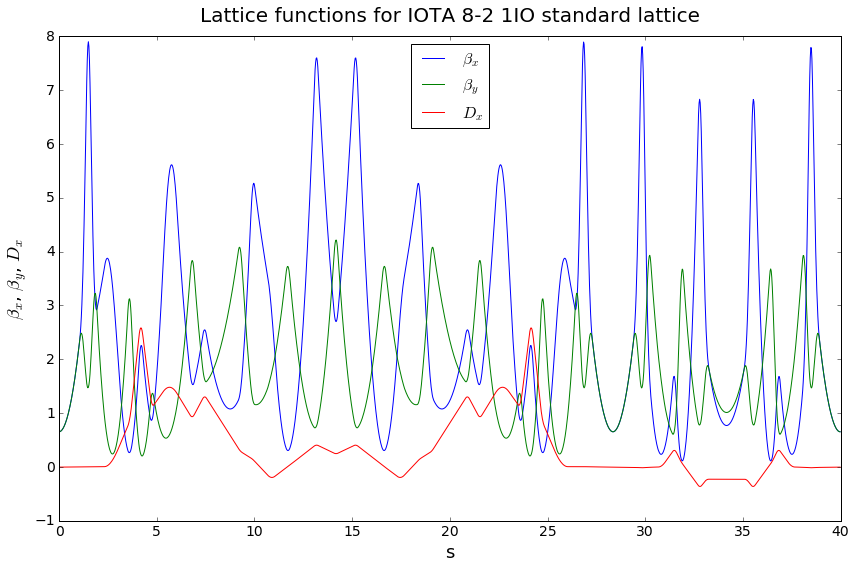

In [11]:
opts.save = False
opts.lattice_name = 'IOTA 8-2 1IO standard lattice'
opts.lf_fns = ['beta_x','beta_y','D_x']
opts.lattice = lattice_dict['t1_1IO_82']['lattice']
opts.lattice_simulator = lattice_dict['t1_1IO_82']['lattice_simulator']
lfplot.plot_sliced_lattice_functions(opts)

## Construct the beam and propagate it

In [12]:
opts.lattice = lattice_dict['t1_1IO_82']['lattice']
opts.lattice_simulator = lattice_dict['t1_1IO_82']['lattice_simulator']
opts.stepper = lattice_dict['t1_1IO_82']['stepper']

In [13]:
def dQ_SC_Gauss(N,emit,ref):
    '''Return dQsc if given normalized emittance'''
    r0 = 1.54e-18 #classical proton radius
    bet = ref.get_beta()
    gam = ref.get_gamma()
    
    dQ = -1.*r0*N/(4*np.pi*emit*bet*gam*gam)
    #print gam*gam*gam
    #print bet*bet
    
    return dQ


def dQ_SC_KV(N,emit,ref):
    '''Return dQsc for a KV beam if given normalized emittance (2x that of Gaussian)'''
    r0 = 1.54e-18 #classical proton radius
    bet = ref.get_beta()
    gam = ref.get_gamma()
    
    dQ = -1.*r0*N/(2*np.pi*emit*bet*gam*gam)
    #print gam*gam*gam
    #print bet*bet
    
    return dQ


g_emit = 20.e-6 #TOTAL geometric emittance of IOTA beam
n_emit = basic_calcs.calc_normalized_emittance(g_emit,opts.beta,opts.gamma)

current = 4.25*1.e-3 #mA of current 
l_IOTA = 39.968229715800064 #length of lattice
rp_perlength = current/(reference_particle.get_beta()*scipy.constants.c*scipy.constants.e)
n_particles = rp_perlength*l_IOTA

dQ = dQ_SC_Gauss(n_particles,n_emit,reference_particle) #calc dQsc_x
dQ_KV = dQ_SC_KV(n_particles,n_emit,reference_particle) #calc dQsc_x

print "Assume a normalized total emittance of {} mm-mrad.".format(n_emit*1.e6)
print "At {} mA current, # of protons filling ring is {:e} or {:e} p+/cm.".format(current*1.e3,n_particles,n_particles/(100.*l_IOTA))
print "Corresponding space charge tune shift in x is {} for KV distribution".format(dQ_KV)

Assume a normalized total emittance of 1.46096398318 mm-mrad.
At 4.25 mA current, # of protons filling ring is 4.854214e+10 or 1.214518e+07 p+/cm.
Corresponding space charge tune shift in x is -0.111187273361 for KV distribution


#### A few notes on distributions for clarity

Note, for the kV-like distribution in coordinate space, the RMS value in x/y is 1/2 the maximum value. That is, in coordinate space, $\sigma_w = 0.5 w_{max}$. For the Gaussian distribution in momentum space, the RMS value is simply the standard deviation ($\sigma_w = \sigma_{p_w}$). The RMS emittance of the bunch (geometric) is then the product of these two values $\epsilon_w = \sigma_w \times \sigma_{p_w}$. 

Thus, we have $\epsilon_w = 0.5 w_{max} \sigma_{p_w}$. So if we specify a maximum coordinate (e.g. $x_{max}$), then we can define $\sigma_{p_w} = 2 \epsilon_w / w_{max}$

For a beam not at a waist, the beam should have a coordinate rotation applied by the twiss parameter matrix in each plane, but since we are injecting at beam waists we don't have to worry about this.

*Defining $x_{max}$*. This follows from the convention of defining $\epsilon_{x} = \sigma_x^2/\beta_x$. For a KV-like distribution in coordinate space, we can relate the maximum x value to the RMS via $\sigma_x = \sqrt{2}/2 x_{max}$. Thus, we have $x_{max} = \sqrt{2 \beta_x \epsilon_x}$.


In [14]:
new_vals = latticework.get_starting_lf(lattice_dict['t1_1IO_82_dQ_1']['lattice_simulator'])

Initial starting lattice functions: betax = 0.627584359882, betay = 0.579814046894, alphax = -0.0343278189644, alphay = 0.0232141439896


In [26]:
n_ppc = 10

opts.gridx = 32
opts.gridy = 32
opts.gridz = 1

n_macro = n_ppc*opts.gridx*opts.gridy
opts.macro_particles = n_macro

#======================= Now setup the bunch and other related options =====================
#Can compute theoretical lattice functions for perfect drift
opts.t = tval
opts.c = cval
opts.new_tune = 0.3
opts.lnll = 1.8
vals = basic_calcs.get_base_nll(opts.lnll, opts.new_tune, opts.t, opts.c)

#Alternatively, we can account for asymmetries in the lattice by grabbing these values directly
new_vals = latticework.get_starting_lf(lattice_dict['t1_1IO_82_dQ_1']['lattice_simulator'])

opts.betae = new_vals[0]
opts.alphae = 0
opts.beta0 = new_vals[0]


dpop = 0.0
opts.dpop = dpop #0.1% dpop

current = 4.25e-3 #mA of current 
rp_perlength = current/(opts.beta*constants.c*constants.e)
bunch_length = opts.lattice.get_length() #effective bunch length is iota lattice length
opts.real_particles = rp_perlength*bunch_length


opts.emit = 0.5*g_emit #Match using the geometric emittance
opts.emits = [opts.emit]

if myrank == 0:
    #construct a bunch and make sure to add longitudinal momentum variation
    #particles = elliptic_beam6d.toyellipticalbeam6D(opts)
    #particles = semi_gaussian6d.semigaussianbeam6D(opts)
    particles = standard_beam6d.toyKVbeam6D(opts)

    for index in range(len(opts.emits)):
        bunch = particles[index]
        #initialH,initialI = elliptic_sp.calc_bunch_H(bunch,opts)
        #bunch_mean = np.mean(initialH)
        #bunch_std = np.std(initialH)
        #bunch_var = (bunch_std/bunch_mean)*100
        #print "Constructed bunch with {} macroparticles, having mean H: {} and std: {}%".format(opts.macro_particles, bunch_mean,bunch_var)
        #now add longitudinal momentum variation
        #For random samples with mean = 0, sigma = sigma, use sigma*np.random.randn(...)
        #bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch))
        bunch[:,4] = bunch_length*(np.random.random(len(bunch)) -0.5) #center at 0
        bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch)) #set dp/p
    
    np.savetxt('my_KV_bunch_82.txt',bunch)         #write the bunch to a text file


bucket_length = bunch_length
particles_file = 'my_KV_bunch_82.txt'
myBunch = read_bunch.read_bunch(particles_file, reference_particle, opts.real_particles, bucket_length, comm)

# generated longitudinal coordinate is z position (beta*c*dt) but Synergia uses
# c*dt.  Divide by beta to get c*dt.
local_particles = myBunch.get_local_particles()
local_particles[:,4] /= opts.beta

Initial starting lattice functions: betax = 0.627584359882, betay = 0.579814046894, alphax = -0.0343278189644, alphay = 0.0232141439896
Loading Synergia particles from txt file:  my_KV_bunch_82.txt
Read  10240  particles


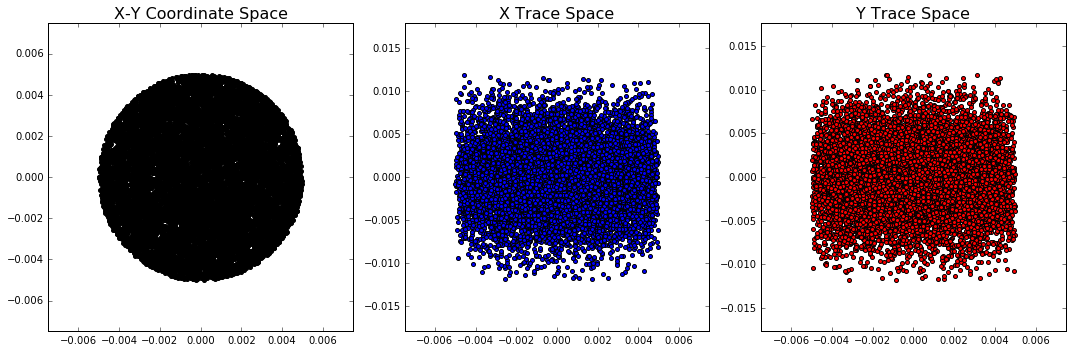

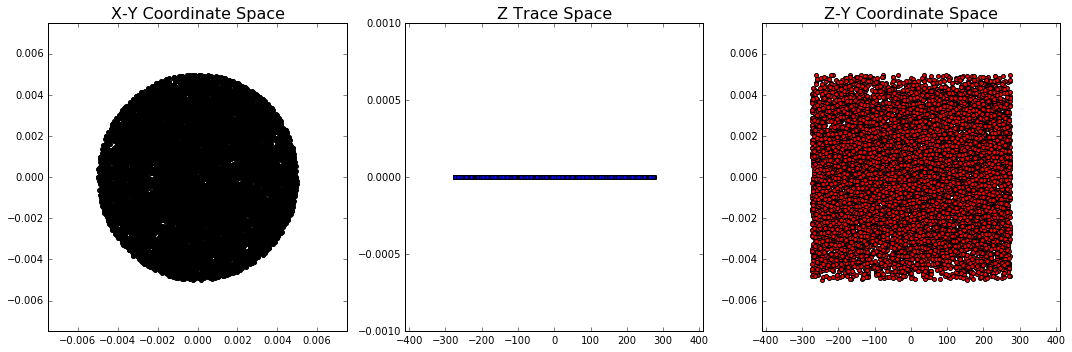

In [25]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [22]:
basic_calcs.calc_properties(myBunch,reference_particle)

rms envelope x: 1.76283745921 mm
rms envelope y: 1.77591176227 mm
maximum x value is : 3.53243342232 mm
maximum y value is : 3.52823618353 mm
rms beta x: 0.621090114761
rms beta y: 0.631253497596
geometric emittance x: 5.00345414255 mm-mrad
geometric emittance y: 4.99619027759 mm-mrad
normalized emittance x: 0.365493314689 mm-mrad
normalized emittance y: 0.364962702434 mm-mrad
mean of xp^2 : 8.05592300319e-06
mean of yp^2 : 7.91471302197e-06
total geometric emittance x: 20.0906206467 mm-mrad
total geometric emittance y: 19.7202084649 mm-mrad


In [23]:
outputdir = 'rssynergia-Benchmark-8pt5-LINEAR'

opts.output_dir = outputdir
workflow.make_path(outputdir)

bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#particle diagnostics - PER TURN
opts.turnsPerDiag = 1
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag, opts.turnsPerDiag)

In [24]:
opts.turns = 100
opts.checkpointperiod = 10
opts.maxturns = opts.turns+1

propagator = synergia.simulation.Propagator(opts.stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)

workflow.cleanup(opts.output_dir)

## Analysis

### Analysis - Beam Envelopes

In [27]:
from base_diagnostics import diagplot

opts.relpath = opts.output_dir

opts.inputfile = opts.output_dir + '/basic.h5'
opts.plots = ['x_std', 'y_std']
plotVals = diagplot.getPlotVals(opts.inputfile, opts.plots)

#define specific value arrays
xmaster = plotVals['s']
xstd = plotVals['x_std']
ystd = plotVals['y_std']

#we want to plot turn 0 and turn 100 on the same plot, so we should separate these specifically
interval = opts.steps 
xstd_0 = xstd[:interval]
xstd_2 = xstd[1*interval:2*interval]
xstd_end = xstd[-1*interval:] 

ystd_0 = ystd[:interval]
ystd_end = ystd[-1*interval:] 

#We can use the same s value for each plot
sval_0 = xmaster[:interval]

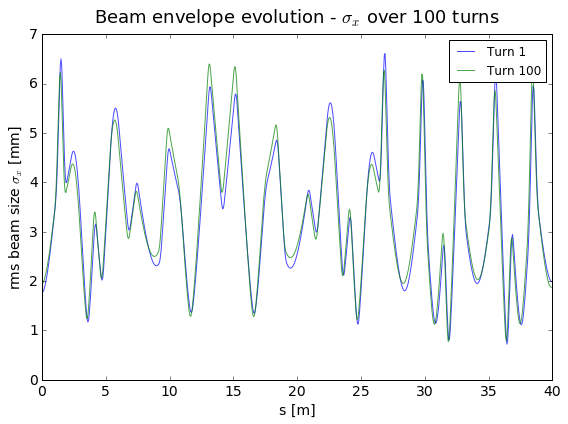

In [28]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(sval_0,xstd_0*1.e3,'b-',alpha=0.7, label='Turn 1') #plot the 1st turn
ax.plot(sval_0,xstd_end*1.e3,'g-',alpha=0.7, label='Turn 100') #plot the 1st turn
axtitle = "Beam envelope evolution - $\sigma_x$ over 100 turns"
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,opts.lattice.get_length()])
ax.legend()
sv_title = 'beam_envelope_x_compare_1mA_2D-600turns.pdf'
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

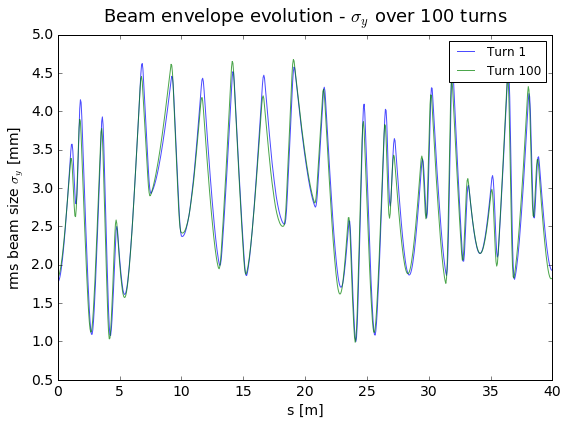

In [29]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(sval_0,ystd_0*1.e3,'b-',alpha=0.7, label='Turn 1') #plot the 1st turn
ax.plot(sval_0,ystd_end*1.e3,'g-',alpha=0.7, label='Turn 100') #plot the 1st turn
axtitle = "Beam envelope evolution - $\sigma_y$ over 100 turns"
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_y$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,opts.lattice.get_length()])
ax.legend()
sv_title = 'beam_envelope_y_compare_1mA_2D-600turns.pdf'
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

### Analysis - Bunch Properties

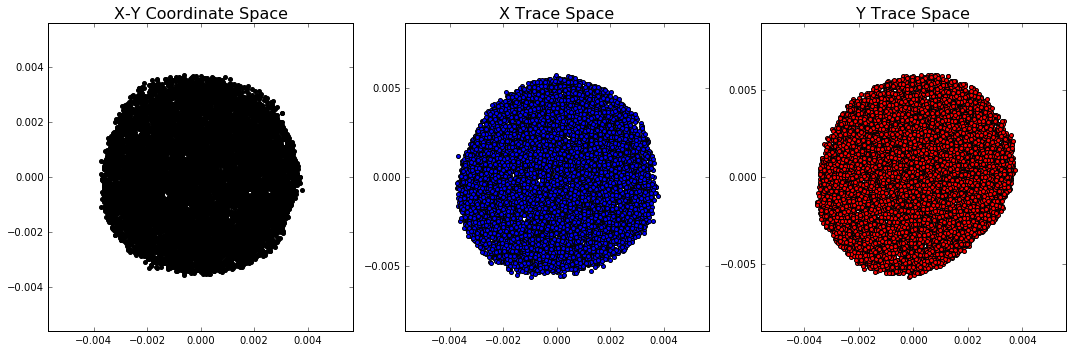

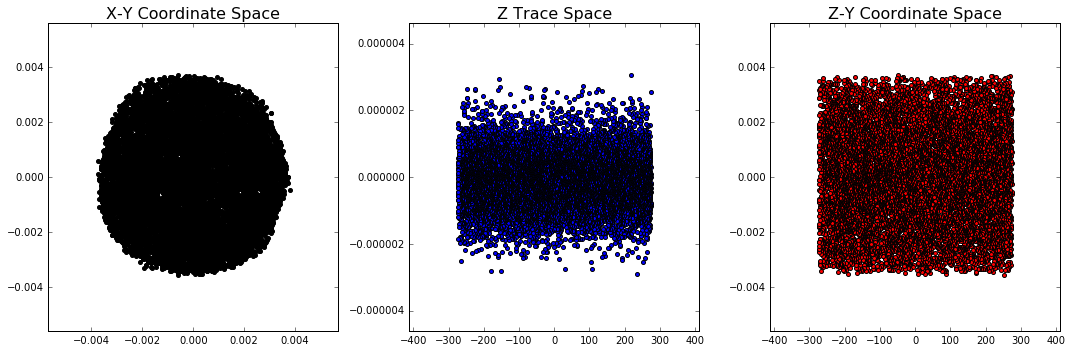

In [30]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [31]:
basic_calcs.calc_properties(myBunch,reference_particle)

rms envelope x: 1.8480183209 mm
rms envelope y: 1.76749420191 mm
maximum x value is : 3.79332175431 mm
maximum y value is : 3.72565498293 mm
rms beta x: 0.675902538923
rms beta y: 0.62558930377
geometric emittance x: 5.05275763548 mm-mrad
geometric emittance y: 4.99374867018 mm-mrad
normalized emittance x: 0.369094846059 mm-mrad
normalized emittance y: 0.36478434741 mm-mrad
mean of xp^2 : 7.47557132059e-06
mean of yp^2 : 7.98247131159e-06
total geometric emittance x: 21.2890011549 mm-mrad
total geometric emittance y: 22.1878874338 mm-mrad


In [32]:
files = elliptic_sp.get_file_list(opts)
twiss = twiss = elliptic_sp.get_toy_twiss(opts)

rms_table = []

for inputfile in files:
    fn = inputfile[-7:-3]
    
    parts = elliptic_sp.get_particles(inputfile)[1]
    header= {}
    header['s_val'] = 0.
    #norm_coords = elliptic_sp.normalized_coordinates(header, part_array, twiss)
    
    x_rms = basic_calcs.get_rms_envelope('x',parts)
    y_rms = basic_calcs.get_rms_envelope('y',parts)
    
    rms_table.append((int(fn),x_rms,y_rms))
    
    #print "File {} : xrms = {:.2f} mm and yrms = {:.2f} mm".format(fn, x_rms*1.e3, y_rms*1.e3)
    
rms_array = np.asarray(rms_table)

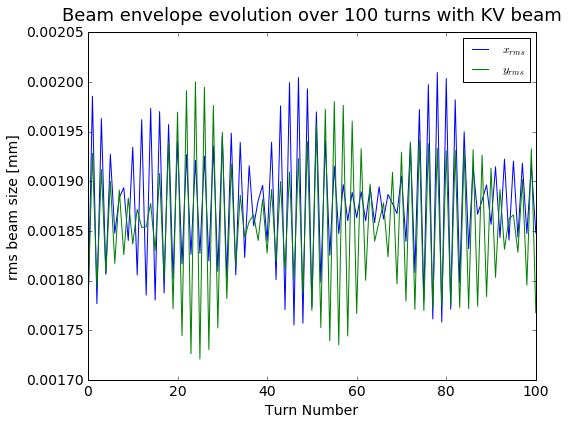

In [33]:
num_turns = rms_array.shape[0]-1

fig = plt.figure(figsize = (8,6))
plt.subplot(1,1,1)
ax = plt.gca()

ax.plot(rms_array[:,0],rms_array[:,1], label = '$x_{rms}$')
ax.plot(rms_array[:,0],rms_array[:,2], label = '$y_{rms}$')

axtitle = "Beam envelope evolution over {} turns with KV beam".format(num_turns)
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("Turn Number",fontsize=14)
ax.set_ylabel("rms beam size [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,num_turns])
ax.legend()
sv_title = 'Benchmark_KV_{}turns_20mm-total-emittance.pdf'.format(num_turns)
fig.tight_layout()
fig.savefig(sv_title,bbox_inches='tight')


plt.show()

### Analysis - Tune depression

In [34]:
def get_particle_coords(ID, num, opts):
    '''Return particle (human) coordinates for particle with ID over first num turns'''
    
    files = elliptic_sp.get_file_list(opts)
    twiss = elliptic_sp.get_toy_twiss(opts)

    part_array = []

    for index,outfile in enumerate(files[:num]):
        
        #if index%20 == 0:
            #print "Grabbing particle {} coordinates for file {}".format(ID,index)
    
        particle = elliptic_sp.get_one_particle(outfile,ID)
    
        if index ==0:
            part_array = particle
        else:
            part_array = np.vstack([part_array,particle])
            
    return part_array

def estimate_tune(x_c, t_s = 1):
    '''Estimate the tune using an FFT of particle coordinates'''
    
    num_used = len(x_c[t_s:])
    tv = np.arange(num_used)*1.0/num_used
    sp = np.fft.fft(x_c[t_s:])
    #plt.plot(tv,sp.real)


    smax = np.max(sp.real)
    m_ind = np.where(sp.real == smax)
    Q_guess =m_ind[0][0]*1./num_used
    if Q_guess > 0.5:
        Q_calc = 1.- Q_guess
    else:
        Q_calc = Q_guess
    #print "Maximum is at {}".format(Q_calc)
    return Q_calc

def estimate_tune_unwrap(x_c,px_c,t_s):
    '''Estimate the tune using a phase unwrap algorithm
    
    Inputs:
        -x_c = normalized spatial coordinate
        -px_c = normalized momentum cooridnate
        -t_s = starting turn value from the array of coordinates
    
    '''
    ang_norm = []
    for x,y in zip(x_c,px_c):
        if x > 0 and y > 0: #quandrant I
            ang_norm.append(np.arctan(y/x))
        elif x < 0 and y > 0: #quandrant II
            ang_norm.append(0.5*np.pi + (0.5*np.pi - np.abs(np.arctan(y/x))))
        elif x < 0 and y < 0: #quadrant III
            ang_norm.append(np.pi + np.abs(np.arctan(y/x)))
        else: #quadrant IV
            ang_norm.append(1.5*np.pi + (0.5*np.pi - np.abs(np.arctan(y/x))))

    #take diference between elements
    diff_ang = np.ediff1d(ang_norm)

    #adjust for wrapping by replacing positive values with 2pi-val
    dff_adjust = []
    for val in diff_ang:
        if val > 0:
            val = val - 2*np.pi
        dff_adjust.append(val)

    #now look at the last 50-80 turns
    #np.mean(dff_adjust[30:])
    t_s = 0
    meantune = -1*(np.mean(dff_adjust[t_s:]))/(2*np.pi)
    #print "{} is the mean tune for particle 0 after turn {}".format(meantune,t_s)
    return meantune

In [36]:
num_t = 100
IDlist = np.arange(200)
tune_array = []
part_array = []

twiss = twiss = elliptic_sp.get_toy_twiss(opts)
header= {}
header['s_val'] = 0.
files = elliptic_sp.get_file_list(opts)[:num_t]

for index,inputfile in enumerate(files):
    #get all of the particles specifed by IDlist
    p_A = elliptic_sp.get_some_particles(inputfile,IDlist)
    norm_coords = elliptic_sp.normalized_coordinates(header, p_A, twiss)
    if len(part_array) == 0:
        #if empty, then replace with norm_coords - first turn
        part_array = norm_coords
    else:
        part_array = np.vstack((part_array,norm_coords))
    
    
#reshape array to be indexable by ID number     
new_PA = part_array.reshape(num_t,len(IDlist),4)

x_tune_array = []
y_tune_array = []
for ID in IDlist:
    x_tune_array.append(estimate_tune(new_PA[:,ID,0]))
    y_tune_array.append(estimate_tune(new_PA[:,ID,2]))

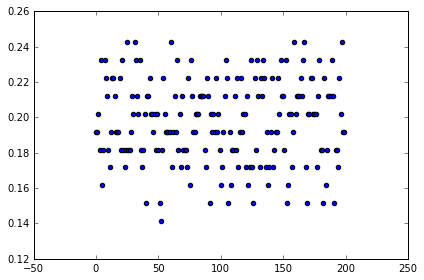

In [37]:
plt.scatter(IDlist,y_tune_array)

The tune spread is easier to observe using a histogram/distribution plot. Note that because we only examined 250 turns, our sampling is rather low, and as a result our resolution for something like a histogram is pretty bad.

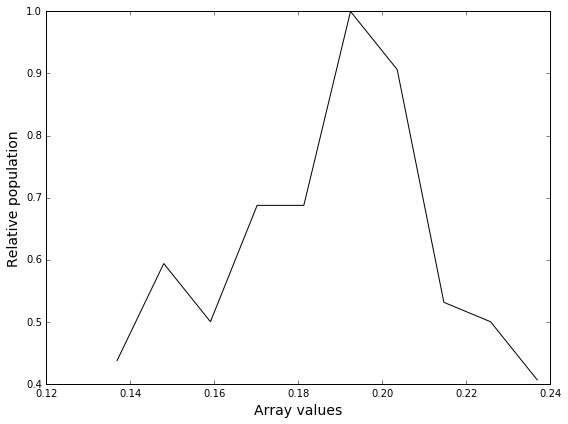

In [39]:
utils.plot_distribution(x_tune_array,10)

We can similarly examine a single particle's trajectory in its normal form.

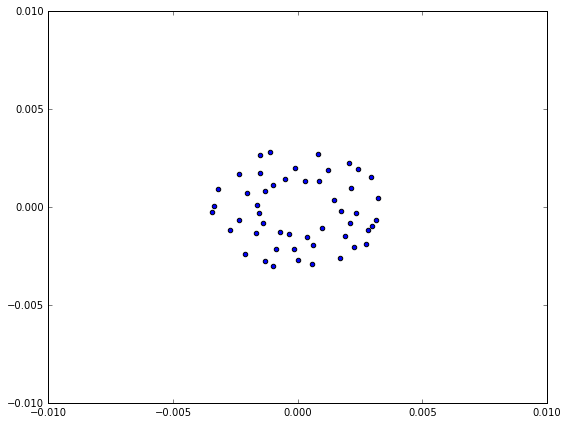

In [40]:
plt.scatter(new_PA[:50,0,0], new_PA[:50,0,1])